# Image Captioning Project (Flickr8k Dataset)

This notebook implements an image captioning model using a pre-trained ResNet-50 as an encoder and an LSTM-based recurrent neural network as a decoder. The model is trained on the Flickr8k dataset to generate descriptive captions for images.

### 1. Setup and Configuration

This section handles necessary imports, downloads NLTK data, and defines the configuration parameters for the model and training process.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import os
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import json
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Download NLTK data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except Exception as e:
    print(f"NLTK punkt tokenizer or required sub-resource not found or error: {e}.")
    print("Attempting to download 'punkt' and 'punkt_tab' resources...")
    try:
        nltk.download('punkt')
        nltk.download('punkt_tab')
        print("NLTK 'punkt' and 'punkt_tab' resources downloaded successfully.")
    except Exception as download_e:
        print(f"Failed to download NLTK resources: {download_e}")
        print("Please ensure you have an active internet connection and try running the script again.")
        print("You might also need to run 'python -m nltk.downloader punkt' and 'python -m nltk.downloader punkt_tab' from your terminal.")


# --- Configuration ---
class Config:
    DATA_DIR = 'flickr8k'
    IMAGES_DIR = os.path.join(DATA_DIR, 'Flicker8k_Dataset')
    CAPTIONS_FILE = os.path.join(DATA_DIR, 'Flickr8k.token.txt')

    CACHED_FEATURES_DIR = 'cached_features'

    EMBED_SIZE = 512
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    VOCAB_THRESHOLD = 5

    BATCH_SIZE = 32 
    NUM_EPOCHS = 20

    LEARNING_RATE = 1e-4
    LOG_STEP = 1200
    SAVE_STEP = 1
    DROPOUT_PROB = 0.3

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    INTEGRATION_STRATEGY = 'hidden_state_init'

print(f"Using device: {Config.DEVICE}")

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs(Config.CACHED_FEATURES_DIR, exist_ok=True)

# Lists to store training metrics for plotting
train_losses = []
val_losses = []
bleu4_scores = []

Using device: cuda


### 2. Vocabulary Class

This class manages the vocabulary, including adding special tokens, building the vocabulary from captions based on a frequency threshold, and mapping words to indices.

In [2]:
class Vocabulary:
    def __init__(self, threshold):
        self.threshold = threshold
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions_list):
        counter = Counter()
        for caption in tqdm(captions_list, desc="Building Vocabulary"):
            tokens = word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, count in counter.items() if count >= self.threshold]
        for word in words:
            self.add_word(word)

        print(f"Vocabulary built with {len(self.word2idx)} unique words (threshold={self.threshold}).")

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### 3. Dataset and Preprocessing

This section defines the `Flickr8kDataset` class, which handles parsing caption files, pre-extracting and caching image features using a `temp_encoder` (ResNet-50), and preparing data for the DataLoader. It also includes `collate_fn` for padding caption sequences.

In [3]:
class Flickr8kDataset(Dataset):
    def __init__(self, captions_file, images_dir, vocab, transform, cached_features_dir, feature_extractor_model=None):
        self.captions_file = captions_file
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        self.cached_features_dir = cached_features_dir

        self.feature_extractor_model = feature_extractor_model
        if self.feature_extractor_model:
            self.feature_extractor_model.to(Config.DEVICE)
            self.feature_extractor_model.eval()

        self.annotations = self._parse_captions()
        self.image_ids = list(self.annotations.keys())

        if not self.image_ids:
            raise ValueError(
                "No image IDs found after parsing captions file. "
                "Please check if 'Flickr8k.token.txt' is correctly formatted "
                "and contains valid image-caption entries."
            )

        print("Checking and caching image features...")
        self._cache_features()

    def _parse_captions(self):
        annotations = {}
        parsed_lines_count = 0
        skipped_lines_count = 0
        with open(self.captions_file, 'r') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    skipped_lines_count += 1
                    continue

                parts = line.split(',', 1)

                if len(parts) < 2:
                    print(f"Warning: Skipping malformed line {line_num} in captions file: '{line}' (Expected at least 2 comma-separated parts).")
                    skipped_lines_count += 1
                    continue

                image_id = parts[0].strip()
                caption_text = parts[1].strip()

                if not image_id.lower().endswith('.jpg'):
                    print(f"Warning: Skipping malformed image ID format on line {line_num}: '{image_id}' (Expected format like 'image.jpg').")
                    skipped_lines_count += 1
                    continue

                if image_id not in annotations:
                    annotations[image_id] = []
                annotations[image_id].append(caption_text)
                parsed_lines_count += 1

        print(f"Finished parsing captions. Successfully parsed {parsed_lines_count} lines. Skipped {skipped_lines_count} lines.")
        if not annotations:
            print("Critical Warning: No valid image-caption entries were parsed from the captions file.")
        return annotations

    def _cache_features(self):
        if self.feature_extractor_model is None:
            print("Feature extractor model not provided; assuming features are already cached.")
            verified_image_ids = []
            for img_id in tqdm(list(self.annotations.keys()), desc="Verifying cached features"):
                cache_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))
                if os.path.exists(cache_path):
                    try:
                        feature = torch.load(cache_path)
                        if feature.shape == torch.Size([2048]):
                            verified_image_ids.append(img_id)
                        else:
                            print(f"Warning: Cached feature for {img_id} at {cache_path} has incorrect shape {feature.shape}. Expected torch.Size([2048]). This file will be marked for re-caching if a feature extractor is provided later.")
                    except Exception as e:
                        print(f"Warning: Could not load cached feature for {img_id} at {cache_path}: {e}. This file will be marked for re-caching if a feature extractor is provided later.")
                else:
                    print(f"Warning: Cached feature file not found for {img_id} at {cache_path}. This image will be skipped if no feature extractor is provided.")

            if len(verified_image_ids) < len(self.annotations.keys()):
                print(f"Warning: {len(self.annotations.keys()) - len(verified_image_ids)} images had missing or problematic cached features. These will be excluded from the dataset.")
            self.image_ids = verified_image_ids
            return

        initial_image_ids = list(self.annotations.keys())

        self.feature_extractor_model.eval()
        self.feature_extractor_model.to(Config.DEVICE)

        problematic_images = set()

        for img_id in tqdm(initial_image_ids, desc="Caching features"):
            img_path = os.path.join(self.images_dir, img_id)
            cache_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))

            if os.path.exists(cache_path):
                try:
                    existing_feature = torch.load(cache_path)
                    if existing_feature.shape == torch.Size([2048]):
                        continue
                    else:
                        print(f"Warning: Existing cached feature for {img_id} at {cache_path} has incorrect shape {existing_feature.shape}. Re-caching.")
                        os.remove(cache_path)
                except Exception as e:
                    print(f"Warning: Could not load existing cached feature for {img_id} at {cache_path}: {e}. Re-caching.")
                    if os.path.exists(cache_path):
                        os.remove(cache_path)

            try:
                if not os.path.exists(img_path):
                    print(f"Warning: Image file not found for {img_id} at {img_path}. Skipping feature caching for this image.")
                    problematic_images.add(img_id)
                    continue

                image = Image.open(img_path).convert('RGB')
                image = self.transform(image).unsqueeze(0).to(Config.DEVICE)

                with torch.no_grad():
                    features = self.feature_extractor_model(image).squeeze(0)

                if features.shape != torch.Size([2048]):
                    print(f"Warning: Feature extraction for {img_id} resulted in unexpected shape {features.shape}. Expected torch.Size([2048]). This feature will NOT be cached.")
                    problematic_images.add(img_id)
                    continue

                torch.save(features.cpu(), cache_path)
            except Exception as e:
                print(f"Error processing image {img_id} during feature caching: {e}")
                problematic_images.add(img_id)
                continue

        print("Feature caching complete.")

        if problematic_images:
            self.image_ids = [img_id for img_id in initial_image_ids if img_id not in problematic_images]
            print(f"Warning: Skipped caching features for {len(problematic_images)} images due to errors or unexpected shapes. These images will be excluded from the dataset.")
            for img_id in list(problematic_images)[:5]:
                print(f"- {img_id}")
            if len(problematic_images) > 5:
                print(f"... and {len(problematic_images) - 5} more.")
            print(f"Adjusted dataset size to {len(self.image_ids) * 5} (from {len(initial_image_ids) * 5}) after filtering problematic images.")
        else:
            self.image_ids = initial_image_ids
            print("All image features cached successfully with correct shapes.")


    def __len__(self):
        return len(self.image_ids) * 5

    def __getitem__(self, idx):
        img_idx = idx // 5
        cap_idx = idx % 5

        img_id = self.image_ids[img_idx]
        caption_text = self.annotations[img_id][cap_idx]

        feature_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))

        try:
            image_feature = torch.load(feature_path)
            if image_feature.shape != torch.Size([2048]):
                raise RuntimeError(f"CRITICAL: Loaded feature for {img_id} from {feature_path} has incorrect shape: {image_feature.shape}. Expected torch.Size([2048]). This indicates a corruption *after* caching or a logic error in filtering.")
        except Exception as e:
            print(f"Error loading cached feature for {img_id} at {feature_path}: {e}. Returning a zero tensor as fallback.")
            image_feature = torch.zeros(2048)

        tokens = word_tokenize(caption_text.lower())
        caption_sequence = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]

        return image_feature, torch.tensor(caption_sequence)

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths

### 4. Encoder (ResNet-50)

This class defines the Vision Encoder using a pre-trained and frozen ResNet-50 model to extract image features.

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        self.model = create_feature_extractor(resnet, return_nodes={'layer4': 'feature_map'})

        for param in self.model.parameters():
            param.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images):
        features = self.model(images)['feature_map']
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        return features

### 5. Decoder (LSTM)

This class defines the Language Decoder, an LSTM network that takes image features and generates caption sequences. It supports different strategies for integrating image features.

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, integration_strategy):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.integration_strategy = integration_strategy

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding_dropout = nn.Dropout(Config.DROPOUT_PROB)

        if self.integration_strategy == 'hidden_state_init':
            self.init_h = nn.Linear(2048, hidden_size)
            self.init_c = nn.Linear(2048, hidden_size)
            self.lstm_input_size = embed_size
        elif self.integration_strategy == 'prepend_feature':
            self.image_feature_linear = nn.Linear(2048, embed_size)
            self.lstm_input_size = embed_size
        else:
            raise ValueError("Invalid integration strategy. Choose 'hidden_state_init' or 'prepend_feature'.")

        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True, dropout=Config.DROPOUT_PROB if num_layers > 1 else 0)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        if self.integration_strategy == 'hidden_state_init':
            h0 = self.init_h(features).unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = self.init_c(features).unsqueeze(0).repeat(self.num_layers, 1, 1)

            captions_input_for_lstm = captions[:, :-1]
            lengths_for_packing = [l - 1 for l in lengths]

            embeddings = self.embedding(captions_input_for_lstm)

            packed_embeddings = nn.utils.rnn.pack_padded_sequence(
                embeddings,
                lengths_for_packing,
                batch_first=True,
                enforce_sorted=True
            )

            hiddens, _ = self.lstm(packed_embeddings, (h0, c0))

            outputs = self.fc(hiddens[0])

        elif self.integration_strategy == 'prepend_feature':
            image_embed = self.image_feature_linear(features).unsqueeze(1)
            image_embed = self.embedding_dropout(image_embed)

            captions_input_for_lstm = captions[:, :-1]
            embeddings_for_lstm = self.embedding(captions_input_for_lstm)

            inputs = torch.cat((image_embed, embeddings_for_lstm), dim=1)

            lengths_for_packing = lengths

            packed_inputs = nn.utils.rnn.pack_padded_sequence(
                inputs,
                lengths_for_packing,
                batch_first=True,
                enforce_sorted=True
            )

            hiddens, _ = self.lstm(packed_inputs)

            outputs = self.fc(hiddens[0])

        return outputs

    def generate_caption(self, features, vocab, max_len=20):
        self.eval()
        with torch.no_grad():
            sequence = []
            state = None

            if self.integration_strategy == 'hidden_state_init':
                h = self.init_h(features).unsqueeze(0).repeat(self.num_layers, 1, 1)
                c = self.init_c(features).unsqueeze(0).repeat(self.num_layers, 1, 1)
                state = (h, c)

                input_token = self.embedding(torch.tensor([vocab('<start>')]).to(Config.DEVICE)).unsqueeze(0)

            elif self.integration_strategy == 'prepend_feature':
                input_token = self.image_feature_linear(features).unsqueeze(0).unsqueeze(0)

            for i in range(max_len):
                output, state = self.lstm(input_token, state)

                output = self.fc(output.squeeze(0))
                
                predicted_idx = output.argmax(dim=1)
                predicted_word = vocab.idx2word[predicted_idx.item()]
                sequence.append(predicted_word)

                if predicted_word == '<end>':
                    break

                input_token = self.embedding(predicted_idx).unsqueeze(0)

            cleaned_sequence = []
            for word in sequence:
                if word not in ['<start>', '<end>']:
                    cleaned_sequence.append(word)
            return ' '.join(cleaned_sequence)

### 6. Training Loop

This function orchestrates the entire training process:
- Prepares the data, builds the vocabulary, and sets up data loaders.
- Initializes the encoder and decoder models, loss function, and optimizer.
- Runs the training loop for a specified number of epochs, including validation and model saving.

In [6]:
def train_model():
    print("Preparing data...")
    all_captions = []
    with open(Config.CAPTIONS_FILE, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',', 1)
            if len(parts) < 2:
                print(f"Skipping malformed line in captions file during vocabulary building: {line}")
                continue
            all_captions.append(parts[1].strip())

    vocab = Vocabulary(Config.VOCAB_THRESHOLD)
    vocab.build_vocabulary(all_captions)
    print(f"Vocabulary size: {len(vocab)}")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    temp_encoder = EncoderCNN()

    dataset = Flickr8kDataset(
        Config.CAPTIONS_FILE,
        Config.IMAGES_DIR,
        vocab,
        transform,
        Config.CACHED_FEATURES_DIR,
        feature_extractor_model=temp_encoder
    )

    del temp_encoder
    torch.cuda.empty_cache()

    train_ids, val_ids = train_test_split(dataset.image_ids, test_size=0.1, random_state=42)
    train_annotations = {img_id: dataset.annotations[img_id] for img_id in train_ids}
    val_annotations = {img_id: dataset.annotations[img_id] for img_id in val_ids}

    train_dataset = Flickr8kDataset(
        Config.CAPTIONS_FILE,
        Config.IMAGES_DIR,
        vocab,
        transform,
        Config.CACHED_FEATURES_DIR,
        feature_extractor_model=None
    )
    train_dataset.image_ids = train_ids
    train_dataset.annotations = train_annotations

    val_dataset = Flickr8kDataset(
        Config.CAPTIONS_FILE,
        Config.IMAGES_DIR,
        vocab,
        transform,
        Config.CACHED_FEATURES_DIR,
        feature_extractor_model=None
    )
    val_dataset.image_ids = val_ids
    val_dataset.annotations = val_annotations


    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=False
    )

    decoder = DecoderRNN(
        Config.EMBED_SIZE,
        Config.HIDDEN_SIZE,
        len(vocab),
        Config.NUM_LAYERS,
        Config.INTEGRATION_STRATEGY
    ).to(Config.DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
    optimizer = optim.Adam(decoder.parameters(), lr=Config.LEARNING_RATE)

    print("Starting training...")
    total_step = len(train_loader)
    for epoch in range(Config.NUM_EPOCHS):
        decoder.train()
        for i, (images_features, captions, lengths) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")):
            images_features = images_features.to(Config.DEVICE)
            captions = captions.to(Config.DEVICE)

            optimizer.zero_grad()

            outputs = decoder(images_features, captions, lengths)

            if Config.INTEGRATION_STRATEGY == 'hidden_state_init':
                targets_for_packing = captions[:, 1:]
                lengths_for_packing_targets = [l - 1 for l in lengths]

            elif Config.INTEGRATION_STRATEGY == 'prepend_feature':
                targets_for_packing = captions
                lengths_for_packing_targets = lengths

            valid_indices = [i for i, l in enumerate(lengths_for_packing_targets) if l > 0]

            if not valid_indices:
                print(f"Warning: Batch {i+1} has no valid target sequences after length adjustment. Skipping loss calculation.")
                continue

            targets_for_packing = targets_for_packing[valid_indices]
            lengths_for_packing_targets = [lengths_for_packing_targets[i] for i in valid_indices]

            packed_targets = nn.utils.rnn.pack_padded_sequence(
                targets_for_packing,
                lengths_for_packing_targets,
                batch_first=True,
                enforce_sorted=True
            )
            targets = packed_targets.data.to(Config.DEVICE)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            if (i+1) % Config.LOG_STEP == 0:
                print(f"Epoch [{epoch+1}/{Config.NUM_EPOCHS}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

        train_losses.append(loss.item())
        print(f"Training Loss after epoch {epoch+1}: {loss.item():.4f}")
        
        decoder.eval()
        val_loss_epoch = 0
        val_steps = 0
        with torch.no_grad():
            for images_features, captions, lengths in val_loader:
                images_features = images_features.to(Config.DEVICE)
                captions = captions.to(Config.DEVICE)
                outputs = decoder(images_features, captions, lengths)
                if Config.INTEGRATION_STRATEGY == 'hidden_state_init':
                    targets_for_packing = captions[:, 1:]
                    lengths_for_packing_targets = [l - 1 for l in lengths]
                elif Config.INTEGRATION_STRATEGY == 'prepend_feature':
                    targets_for_packing = captions
                    lengths_for_packing_targets = lengths
                valid_indices = [i for i, l in enumerate(lengths_for_packing_targets) if l > 0]
                if not valid_indices:
                    continue
                targets_for_packing = targets_for_packing[valid_indices]
                lengths_for_packing_targets = [lengths_for_packing_targets[i] for i in valid_indices]
                packed_targets = nn.utils.rnn.pack_padded_sequence(
                    targets_for_packing,
                    lengths_for_packing_targets,
                    batch_first=True,
                    enforce_sorted=True
                )
                targets = packed_targets.data.to(Config.DEVICE)
                val_loss_epoch += criterion(outputs, targets).item()
                val_steps += 1
        avg_val_loss = val_loss_epoch / max(1, val_steps)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss after epoch {epoch+1}: {avg_val_loss:.4f}")

        bleu4 = evaluate_bleu4(decoder, vocab, val_dataset, transform, num_samples=len(val_dataset))
        bleu4_scores.append(bleu4)
        print(f"BLEU-4 Score after epoch {epoch+1}: {bleu4:.4f}")

        model_save_dir = 'models'
        os.makedirs(model_save_dir, exist_ok=True)

        if (epoch+1) % Config.SAVE_STEP == 0:
            model_path = os.path.join(model_save_dir, f'decoder-epoch-{epoch+1}.pth')
            torch.save(decoder.state_dict(), model_path)
            vocab_path = os.path.join(model_save_dir, f'vocab-{epoch+1}.json')
            with open(vocab_path, 'w') as f:
                json.dump({'word2idx': vocab.word2idx, 'idx2word': vocab.idx2word}, f)
            print(f"Model and vocabulary saved to {model_path} and {vocab_path}")

    print("Training finished.")
    return decoder, vocab, val_dataset

### 7. Inference Function

This function demonstrates how to use the trained encoder and decoder to generate a caption for a single new image.

In [7]:
def generate_caption_for_image(image_path, encoder, decoder, vocab, transform, max_len=20):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(Config.DEVICE)

        features = encoder(image)

        caption = decoder.generate_caption(features, vocab, max_len)
        return caption

### 8. Evaluation (BLEU Score)

These functions provide a way to evaluate the model's performance on a subset of the dataset using BLEU scores, a common metric for machine translation and text generation.

In [8]:
def evaluate_model(encoder, decoder, vocab, transform, dataset, num_samples=100):
    print(f"\n--- Starting Evaluation on {num_samples} images ---")
    encoder.eval()
    decoder.eval()

    references_all = []
    hypotheses_all = []

    eval_image_ids = random.sample(dataset.image_ids, min(num_samples, len(dataset.image_ids)))

    for img_id in tqdm(eval_image_ids, desc="Evaluating"):
        img_path = os.path.join(Config.IMAGES_DIR, img_id)

        generated_caption_text = generate_caption_for_image(img_path, encoder, decoder, vocab, transform)
        hypotheses_all.append(word_tokenize(generated_caption_text.lower()))

        reference_captions_for_img = dataset.annotations[img_id]

        tokenized_references = [word_tokenize(cap.lower()) for cap in reference_captions_for_img]
        references_all.append(tokenized_references)

    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    bleu_scores = []

    for hyp, refs in zip(hypotheses_all, references_all):
        sf = nltk.translate.bleu_score.SmoothingFunction()
        bleu_1_scores.append(nltk.translate.bleu_score.sentence_bleu(refs, hyp, weights=(1, 0, 0, 0), smoothing_function=sf.method4))
        bleu_2_scores.append(nltk.translate.bleu_score.sentence_bleu(refs, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=sf.method4))
        bleu_3_scores.append(nltk.translate.bleu_score.sentence_bleu(refs, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=sf.method4))
        bleu_4_scores.append(nltk.translate.bleu_score.sentence_bleu(refs, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=sf.method4))
        bleu_scores.append(nltk.translate.bleu_score.sentence_bleu(refs, hyp, smoothing_function=sf.method4))


    avg_bleu1 = np.mean(bleu_1_scores)
    avg_bleu2 = np.mean(bleu_2_scores)
    avg_bleu3 = np.mean(bleu_3_scores)
    avg_bleu4 = np.mean(bleu_4_scores)
    avg_bleu = np.mean(bleu_scores)

    print(f"\n--- Evaluation Results (on {len(hypotheses_all)} images) ---")
    print(f"Average BLEU-1: {avg_bleu1:.4f}")
    print(f"Average BLEU-2: {avg_bleu2:.4f}")
    print(f"Average BLEU-3: {avg_bleu3:.4f}")
    print(f"Average BLEU-4: {avg_bleu4:.4f}")
    print(f"Average BLEU: {avg_bleu:.4f}")

    print("Evaluation finished.")

    return bleu_scores

def evaluate_bleu4(decoder, vocab, dataset, transform, num_samples=30):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    decoder.eval()
    hypotheses = []
    references = []
    sampled_ids = random.sample(dataset.image_ids, min(num_samples, len(dataset.image_ids)))
    for img_id in tqdm(sampled_ids, desc="Evaluating"):
        img_path = os.path.join(Config.IMAGES_DIR, img_id)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(Config.DEVICE)
        encoder = EncoderCNN().to(Config.DEVICE)
        encoder.eval()
        with torch.no_grad():
            features = encoder(image)
            caption = decoder.generate_caption(features, vocab)
        hypotheses.append(word_tokenize(caption.lower()))
        ref_caps = dataset.annotations[img_id]
        references.append([word_tokenize(cap.lower()) for cap in ref_caps])
    sf = SmoothingFunction().method4
    bleu4_scores = [sentence_bleu(refs, hyp, smoothing_function=sf) for refs, hyp in zip(references, hypotheses)]
    return np.mean(bleu4_scores)

### 9. Main Execution and Plotting

This block runs the training process, performs inference on a random image, evaluates the model, and then generates plots for training/validation loss and BLEU-4 scores over epochs.

In [9]:
print(f"Starting Local Image Captioning Project on {Config.DEVICE}")
print(f"Selected Integration Strategy: {Config.INTEGRATION_STRATEGY}")

# Train the model
trained_decoder, loaded_vocab, val_dataset = train_model()

# Image transformation pipeline for inference (must be same as training)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize a fresh encoder for inference (it's frozen, so no training needed)
inference_encoder = EncoderCNN().to(Config.DEVICE)
inference_encoder.eval()

# --- Test inference on a random image from the dataset ---
print("\n--- Testing Inference on a Random Image ---")

dummy_vocab_for_dataset = Vocabulary(Config.VOCAB_THRESHOLD)

temp_dataset = Flickr8kDataset(
    Config.CAPTIONS_FILE,
    Config.IMAGES_DIR,
    dummy_vocab_for_dataset,
    inference_transform,
    Config.CACHED_FEATURES_DIR,
    feature_extractor_model=None
)

Starting Local Image Captioning Project on cuda
Selected Integration Strategy: hidden_state_init
Preparing data...


Building Vocabulary: 100%|██████████| 40456/40456 [00:03<00:00, 11391.71it/s]


Vocabulary built with 3006 unique words (threshold=5).
Vocabulary size: 3006
Finished parsing captions. Successfully parsed 40455 lines. Skipped 1 lines.
Checking and caching image features...


Caching features: 100%|██████████| 8091/8091 [00:08<00:00, 915.75it/s]


Feature caching complete.
All image features cached successfully with correct shapes.
Finished parsing captions. Successfully parsed 40455 lines. Skipped 1 lines.
Checking and caching image features...
Feature extractor model not provided; assuming features are already cached.


Verifying cached features: 100%|██████████| 8091/8091 [00:04<00:00, 1732.27it/s]


Finished parsing captions. Successfully parsed 40455 lines. Skipped 1 lines.
Checking and caching image features...
Feature extractor model not provided; assuming features are already cached.


Verifying cached features: 100%|██████████| 8091/8091 [00:04<00:00, 1782.34it/s]


Starting training...


Epoch 1/20: 100%|██████████| 1138/1138 [00:36<00:00, 31.46it/s]


Training Loss after epoch 1: 3.4707
Validation Loss after epoch 1: 3.3933


Evaluating: 100%|██████████| 810/810 [08:19<00:00,  1.62it/s]


BLEU-4 Score after epoch 1: 0.1109
Model and vocabulary saved to models\decoder-epoch-1.pth and models\vocab-1.json


Epoch 2/20: 100%|██████████| 1138/1138 [00:36<00:00, 31.01it/s]


Training Loss after epoch 2: 3.3457
Validation Loss after epoch 2: 3.0446


Evaluating: 100%|██████████| 810/810 [08:22<00:00,  1.61it/s]


BLEU-4 Score after epoch 2: 0.1475
Model and vocabulary saved to models\decoder-epoch-2.pth and models\vocab-2.json


Epoch 3/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.25it/s]


Training Loss after epoch 3: 2.5569
Validation Loss after epoch 3: 2.8625


Evaluating: 100%|██████████| 810/810 [08:12<00:00,  1.65it/s]


BLEU-4 Score after epoch 3: 0.1691
Model and vocabulary saved to models\decoder-epoch-3.pth and models\vocab-3.json


Epoch 4/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.73it/s]


Training Loss after epoch 4: 2.7017
Validation Loss after epoch 4: 2.7536


Evaluating: 100%|██████████| 810/810 [07:38<00:00,  1.77it/s]


BLEU-4 Score after epoch 4: 0.1825
Model and vocabulary saved to models\decoder-epoch-4.pth and models\vocab-4.json


Epoch 5/20: 100%|██████████| 1138/1138 [00:36<00:00, 31.11it/s]


Training Loss after epoch 5: 2.3772
Validation Loss after epoch 5: 2.6818


Evaluating: 100%|██████████| 810/810 [07:28<00:00,  1.80it/s]


BLEU-4 Score after epoch 5: 0.1796
Model and vocabulary saved to models\decoder-epoch-5.pth and models\vocab-5.json


Epoch 6/20: 100%|██████████| 1138/1138 [00:36<00:00, 30.86it/s]


Training Loss after epoch 6: 2.3360
Validation Loss after epoch 6: 2.6337


Evaluating: 100%|██████████| 810/810 [08:02<00:00,  1.68it/s]


BLEU-4 Score after epoch 6: 0.1833
Model and vocabulary saved to models\decoder-epoch-6.pth and models\vocab-6.json


Epoch 7/20: 100%|██████████| 1138/1138 [00:36<00:00, 31.03it/s]


Training Loss after epoch 7: 2.2443
Validation Loss after epoch 7: 2.6010


Evaluating: 100%|██████████| 810/810 [08:14<00:00,  1.64it/s]


BLEU-4 Score after epoch 7: 0.1907
Model and vocabulary saved to models\decoder-epoch-7.pth and models\vocab-7.json


Epoch 8/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.73it/s]


Training Loss after epoch 8: 2.3152
Validation Loss after epoch 8: 2.5764


Evaluating: 100%|██████████| 810/810 [08:01<00:00,  1.68it/s]


BLEU-4 Score after epoch 8: 0.1943
Model and vocabulary saved to models\decoder-epoch-8.pth and models\vocab-8.json


Epoch 9/20: 100%|██████████| 1138/1138 [00:36<00:00, 31.02it/s]


Training Loss after epoch 9: 2.1908
Validation Loss after epoch 9: 2.5595


Evaluating: 100%|██████████| 810/810 [07:21<00:00,  1.83it/s]


BLEU-4 Score after epoch 9: 0.1906
Model and vocabulary saved to models\decoder-epoch-9.pth and models\vocab-9.json


Epoch 10/20: 100%|██████████| 1138/1138 [00:36<00:00, 30.82it/s]


Training Loss after epoch 10: 2.2136
Validation Loss after epoch 10: 2.5523


Evaluating: 100%|██████████| 810/810 [07:54<00:00,  1.71it/s]


BLEU-4 Score after epoch 10: 0.1965
Model and vocabulary saved to models\decoder-epoch-10.pth and models\vocab-10.json


Epoch 11/20: 100%|██████████| 1138/1138 [00:41<00:00, 27.24it/s]


Training Loss after epoch 11: 1.7142
Validation Loss after epoch 11: 2.5480


Evaluating: 100%|██████████| 810/810 [08:39<00:00,  1.56it/s]


BLEU-4 Score after epoch 11: 0.1997
Model and vocabulary saved to models\decoder-epoch-11.pth and models\vocab-11.json


Epoch 12/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.75it/s]


Training Loss after epoch 12: 2.0848
Validation Loss after epoch 12: 2.5446


Evaluating: 100%|██████████| 810/810 [07:17<00:00,  1.85it/s]


BLEU-4 Score after epoch 12: 0.1960
Model and vocabulary saved to models\decoder-epoch-12.pth and models\vocab-12.json


Epoch 13/20: 100%|██████████| 1138/1138 [00:35<00:00, 31.68it/s]


Training Loss after epoch 13: 1.8816
Validation Loss after epoch 13: 2.5481


Evaluating: 100%|██████████| 810/810 [07:16<00:00,  1.86it/s]


BLEU-4 Score after epoch 13: 0.2017
Model and vocabulary saved to models\decoder-epoch-13.pth and models\vocab-13.json


Epoch 14/20: 100%|██████████| 1138/1138 [00:36<00:00, 30.83it/s]


Training Loss after epoch 14: 1.6593
Validation Loss after epoch 14: 2.5547


Evaluating: 100%|██████████| 810/810 [07:51<00:00,  1.72it/s]


BLEU-4 Score after epoch 14: 0.1950
Model and vocabulary saved to models\decoder-epoch-14.pth and models\vocab-14.json


Epoch 15/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.50it/s]


Training Loss after epoch 15: 1.8389
Validation Loss after epoch 15: 2.5661


Evaluating: 100%|██████████| 810/810 [08:01<00:00,  1.68it/s]


BLEU-4 Score after epoch 15: 0.1895
Model and vocabulary saved to models\decoder-epoch-15.pth and models\vocab-15.json


Epoch 16/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.22it/s]


Training Loss after epoch 16: 1.5916
Validation Loss after epoch 16: 2.5803


Evaluating: 100%|██████████| 810/810 [08:02<00:00,  1.68it/s]


BLEU-4 Score after epoch 16: 0.1965
Model and vocabulary saved to models\decoder-epoch-16.pth and models\vocab-16.json


Epoch 17/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.18it/s]


Training Loss after epoch 17: 1.5515
Validation Loss after epoch 17: 2.5844


Evaluating: 100%|██████████| 810/810 [07:41<00:00,  1.76it/s]


BLEU-4 Score after epoch 17: 0.1861
Model and vocabulary saved to models\decoder-epoch-17.pth and models\vocab-17.json


Epoch 18/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.49it/s]


Training Loss after epoch 18: 1.6967
Validation Loss after epoch 18: 2.6052


Evaluating: 100%|██████████| 810/810 [07:27<00:00,  1.81it/s]


BLEU-4 Score after epoch 18: 0.1967
Model and vocabulary saved to models\decoder-epoch-18.pth and models\vocab-18.json


Epoch 19/20: 100%|██████████| 1138/1138 [00:37<00:00, 30.16it/s]


Training Loss after epoch 19: 1.4214
Validation Loss after epoch 19: 2.6253


Evaluating: 100%|██████████| 810/810 [08:04<00:00,  1.67it/s]


BLEU-4 Score after epoch 19: 0.1817
Model and vocabulary saved to models\decoder-epoch-19.pth and models\vocab-19.json


Epoch 20/20: 100%|██████████| 1138/1138 [00:40<00:00, 27.93it/s]


Training Loss after epoch 20: 1.4865
Validation Loss after epoch 20: 2.6406


Evaluating: 100%|██████████| 810/810 [07:38<00:00,  1.77it/s]


BLEU-4 Score after epoch 20: 0.1887
Model and vocabulary saved to models\decoder-epoch-20.pth and models\vocab-20.json
Training finished.

--- Testing Inference on a Random Image ---
Finished parsing captions. Successfully parsed 40455 lines. Skipped 1 lines.
Checking and caching image features...
Feature extractor model not provided; assuming features are already cached.


Verifying cached features: 100%|██████████| 8091/8091 [00:05<00:00, 1548.52it/s]


In [ ]:
  # Evaluate BLEU-4 score for a model file
def evaluate_bleu4_score(model_file, vocab_file, dataset, transform, num_samples=30):
    print(f"Loading model from {model_file} and vocabulary from {vocab_file}...")
    with open(vocab_file, 'r') as f:
        vocab_data = json.load(f)
        vocab = Vocabulary(Config.VOCAB_THRESHOLD)
        vocab.word2idx = vocab_data['word2idx']
        vocab.idx2word = {int(k): v for k, v in vocab_data['idx2word'].items()}
    decoder = DecoderRNN(
        Config.EMBED_SIZE,
        Config.HIDDEN_SIZE,
        len(vocab),
        Config.NUM_LAYERS,
        Config.INTEGRATION_STRATEGY
    ).to(Config.DEVICE)
    decoder.load_state_dict(torch.load(model_file, map_location=Config.DEVICE))
    decoder.eval()

    bleu4_score = evaluate_bleu4(decoder, vocab, dataset, transform, num_samples=num_samples)
    return bleu4_score

scores = evaluate_bleu4_score(
    model_file="./models/decoder-epoch-13.pth",
    vocab_file="./models/vocab-13.json",
    dataset=val_dataset,
    transform=inference_transform,
    num_samples=len(val_dataset) 
)
#scores = evaluate_model(inference_encoder, trained_decoder, loaded_vocab, inference_transform, temp_dataset, num_samples=100)
print(f"BLEU-4 Score for the model: {np.mean(scores):.4f}")

Loading model from ./models/decoder-epoch-13.pth and vocabulary from ./models/vocab-13.json...


Evaluating: 100%|██████████| 810/810 [07:38<00:00,  1.77it/s]


BLEU-4 Score for the model: 0.2017


In [47]:
scores = evaluate_model(inference_encoder, trained_decoder, loaded_vocab, inference_transform, val_dataset, num_samples=len(val_dataset))



--- Starting Evaluation on 4050 images ---


Evaluating: 100%|██████████| 810/810 [00:23<00:00, 34.76it/s]



--- Evaluation Results (on 810 images) ---
Average BLEU-1: 0.5969
Average BLEU-2: 0.3968
Average BLEU-3: 0.2729
Average BLEU-4: 0.1887
Average BLEU: 0.1887
Evaluation finished.


### Plots

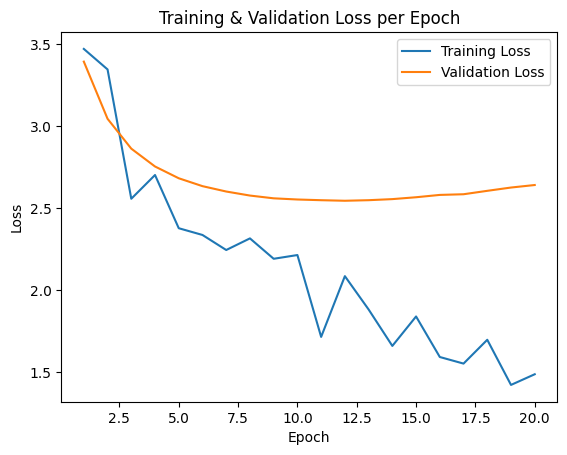

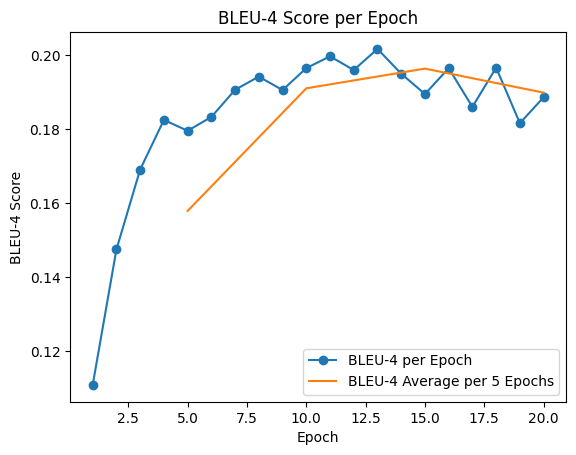

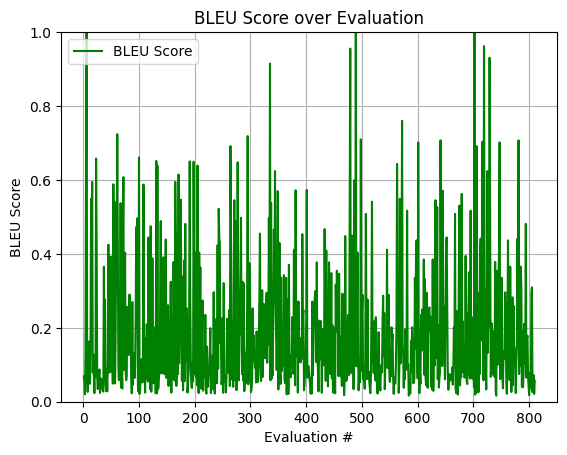

In [48]:
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
#plt.savefig('loss_per_epoch.png')

# Calculate BLEU-4 per 5 epochs from the existing bleu4_scores
epochs_5_epoch = []
scores_5_epoch = []
for i in range(0, len(bleu4_scores), 5):
    # Calculate the average BLEU score for the current 5-epoch window,
    window_scores = bleu4_scores[i:i+5],
    if window_scores:
        avg_score = np.mean(window_scores),
        # The epoch number for this average will be the end of the window,
        epochs_5_epoch.append(i+5),
        scores_5_epoch.append(avg_score)

plt.figure()
plt.plot(range(1, len(bleu4_scores)+1), bleu4_scores, marker='o', label='BLEU-4 per Epoch')
plt.xlabel('Epoch')
plt.ylabel('BLEU-4 Score')
plt.title('BLEU-4 Score per Epoch')
 
plt.plot(epochs_5_epoch, scores_5_epoch, label='BLEU-4 Average per 5 Epochs'),
plt.xlabel('Epoch'),
plt.ylabel('BLEU-4 Score'),
plt.title('BLEU-4 Score per Epoch'),
plt.legend(),
plt.savefig('bleu4_per_epoch.png'),
#plt.savefig('bleu4_per_epoch.png')

plt.figure()
#plt.subplot(1, 2, 2)
plt.plot(range(1, len(scores) + 1), scores, label='BLEU Score', color='green')
plt.xlabel('Evaluation #')
plt.ylabel('BLEU Score')
plt.title('BLEU Score over Evaluation')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


## Test with real pictures

Loading model from ./models/decoder-epoch-13.pth and vocabulary from ./models/vocab-13.json...
Generated Caption: a woman in a pink dress walks on a city street .


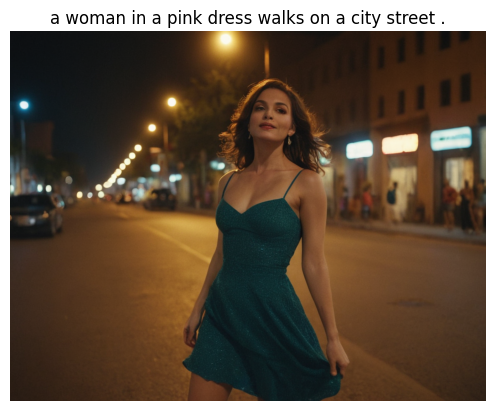

In [18]:
img_path = r"./tests/img01.png"
model_file="./models/decoder-epoch-13.pth"
vocab_file="./models/vocab-13.json"
img = Image.open(img_path).convert("RGB")

print(f"Loading model from {model_file} and vocabulary from {vocab_file}...")
with open(vocab_file, 'r') as f:
    vocab_data = json.load(f)
    vocab = Vocabulary(Config.VOCAB_THRESHOLD)
    vocab.word2idx = vocab_data['word2idx']
    vocab.idx2word = {int(k): v for k, v in vocab_data['idx2word'].items()}
decoder = DecoderRNN(
    Config.EMBED_SIZE,
    Config.HIDDEN_SIZE,
    len(vocab),
    Config.NUM_LAYERS,
    Config.INTEGRATION_STRATEGY
).to(Config.DEVICE)
decoder.load_state_dict(torch.load(model_file, map_location=Config.DEVICE))
decoder.eval()

caption = generate_caption_for_image(img_path, inference_encoder, decoder, vocab, inference_transform)
print("Generated Caption:", caption)

plt.imshow(img)
plt.title(caption)
plt.axis("off")
plt.show()